In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def RK4_step(r, y, h, g, density_profile, *P):
    """
    Implements a single step of a fourth-order, explicit Runge-Kutta scheme
    """
    rhalf = r + 0.5*h
    k1 = h * g(r, y, density_profile, *P)
    k2 = h * g(rhalf, y + 0.5*k1, density_profile, *P)
    k3 = h * g(rhalf, y + 0.5*k2, density_profile, *P)
    k4 = h * g(r + h, y + k3, density_profile, *P)
    
    return y + (k1 + 2*k2 + 2*k3 + k4)/6

In [52]:
def odeSolve(r0, y0, rmax, h, RHS, RHS_near0, density_profile, method, *P):
    """
    ODE driver with constant step-size, allowing systems of ODE's
    """
    a_H = P[2]
    
    # make array of radii and find length of array
    r = np.arange(r0, rmax+h, h) * a_H
    N, = r.shape

    # find out if we are solving a scalar ODE or a system of ODEs, and allocate space accordingly
    
    if type(y0) in [int, float]:  # check if primitive type -- means only one eqn
        neqn = 1
        y = np.zeros(N)
    else:                         # otherwise assume a numpy array -- a system of more than one eqn
        neqn, = y0.shape
        y = np.zeros((N, neqn))

    # set first element of solution to initial conditions (possibly a vector) 
    y[0] = y0
    
    # Use the RHS near r=0 for the first iteration to avoid dividing by 0
    y[1] = RHS_near0(r[1], *P)

    # Iterate through the rest of r using the actual RHS
    for i in range(1, N-1):
        y[i+1] = method(r[i], y[i], h, RHS, density_profile, *P)

    return r, y

In [58]:
def RHS(r, y, density_profile, *P):
    '''
    Right hand side of the first-order ODEs to solve
    '''
    g = y[1]

    G = P[0]
    a_H = P[2]
    
    return np.array([-g, a_H*(4*np.pi*G*density_profile(r, *P) - 2*g/r)])

In [64]:
def RHS_near0(r, *P):
    '''
    Right hand side of the first-order ODEs to solve
    '''
    G = P[0]
    rho_c = 1.478e-7 # critical density
    
    return np.array([1-(2/3)*np.pi*G*rho_c*r**2, (4/3)*np.pi*G*rho_c*r])

In [6]:
def Rho(r, *P):
    '''
    First density profile to test
    '''
    G, v_H, a_H = P
    return v_H**2 / ((r**2 + a_H**2)*(4*np.pi*G))

In [7]:
def v_r(r, g, *P):
    '''
    Calculate v(r) using numerical result for g
    '''
    v_H, a_H = P
    return (g*r)**0.5 / v_H

In [8]:
def v_analytic(r1):
    '''
    Define analytic solution for the first profile
    '''
    return (1 - (1/r1)*np.arctan(r1))**0.5

#### Note: For this entire notebook $\tilde{r}$ and $\tilde{g}$ are named as r1 and g1 respectively, and $\tilde{v}$ is just v. Other variable naming should match the assignment instructions

In [65]:
# Setup variables and parameters
r0 = 0 # dimensionless r
y0 = np.array([1, 0]) # initial conditions for phi and g
rmax = 100 # dimensionless r
G = 4.517e-30 # in parsecs and solar masses
v_H = [1, 10, 1, 10]
a_H = [1, 1, 10, 0.1]
h = 0.01 # step size

v = []
v_true = []

# Iterate over each v_H and a_H pair
for i in range(4):
    
    # Solve for first density profile
    r, y = odeSolve(r0, y0, rmax, h, RHS, RHS_near0, Rho, RK4_step, G, v_H[i], a_H[i])
    rho = Rho(r, G, v_H[i], a_H[i])

    # r1 = r / a_H[i] # change r back to dimensionless
    v.append(v_r(r, y[:, 1], v_H[i], a_H[i])) # Calculate numerical result for v and append

    v_true.append(v_analytic(r1)) # Calculate analytic solution and append

C:\Users\wxs07\AppData\Local\Temp\ipykernel_5784\1419485712.py:2: RuntimeWarning: divide by zero encountered in divide
  return (1 - (1/r1)*np.arctan(r1))**0.5
C:\Users\wxs07\AppData\Local\Temp\ipykernel_5784\1419485712.py:2: RuntimeWarning: invalid value encountered in multiply
  return (1 - (1/r1)*np.arctan(r1))**0.5


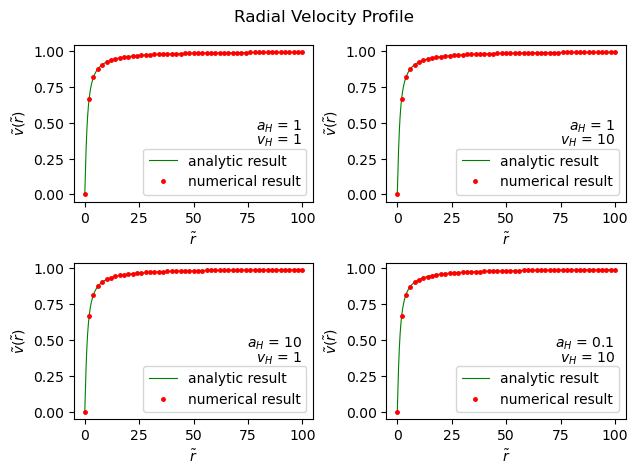

In [72]:
# Plot my results, plotting the numerical result over the analytic to compare
fig, axs = plt.subplots(2, 2)
fig.suptitle("Radial Velocity Profile")

for i, ax in enumerate(axs.reshape(-1)):
    ax.plot(r1, v_true[i], "g", label=r"analytic result", lw=0.8)
    # Plotting every 200 points to make plot points less crowded
    ax.plot(r1[0::200], v[i][0::200], "r.", label=r"numerical result", markersize=5)
    ax.text(100, 0.45, f'$a_H$ = {a_H[i]}', horizontalalignment='right')
    ax.text(100, 0.35, f'$v_H$ = {v_H[i]}', horizontalalignment='right')

    ax.set_xlabel(r"$\tilde{r}$")
    ax.set_ylabel(r"$\tilde{v}(\tilde{r})$")

    ax.legend()

fig.tight_layout()
plt.savefig('vel_profile_rho.png', dpi=300)
plt.show()

In [83]:
def NFW(r, *P):
    '''
    The NFW density profile
    '''
    rho_c, r_s, delta_c = P[1:]
    return delta_c*rho_c / ((r/r_s + 0.01)*(1 + r/r_s)**2)

In [87]:
# Setup variables and parameters
r0 = 0 # dimensionless r
y0 = np.array([1, 0]) # initial conditions for phi and g
rmax = 100 # dimensionless r
G = 4.517e-30 # in parsecs and solar masses
rho_c = 10
r_s = 10
delta_c = 10
h = 0.01 # step size

# Solve for first density profile
r, y = odeSolve(r0, y0, rmax, h, RHS, RHS_near0, NFW, RK4_step, G, rho_c, r_s, delta_c)
rho = NFW(r, G, rho_c, r_s, delta_c)

# transform variables to dimensionless parameters
r1 = r / a_H
g1 = y[:, 1] / (r*G*rho)

v = (y[:, 1]*r)**0.5

C:\Users\wxs07\AppData\Local\Temp\ipykernel_5784\179116673.py:17: RuntimeWarning: invalid value encountered in divide
  g1 = y[:, 1] / (r*G*rho)


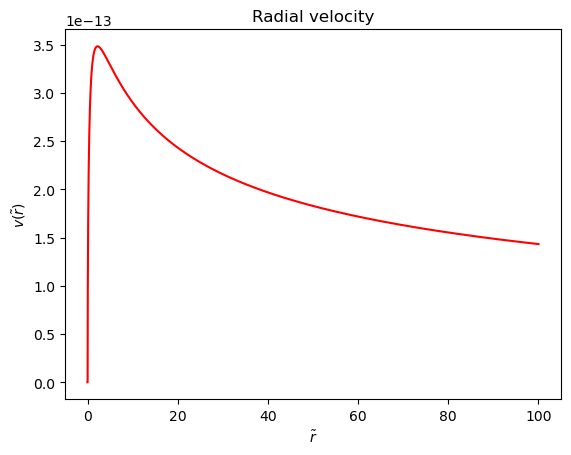

In [88]:
plt.title("Radial velocity")

plt.plot(r1, v, "r", label=r"v")

plt.xlabel(r"$\tilde{r}$")
plt.ylabel(r"$v(\tilde{r})$")

plt.show()

In [74]:
# Test convergence for first density profile

# Setup variables and parameters
r0 = 0 # dimensionless r
y0 = np.array([1, 0]) # initial conditions for phi and g
rmax = 100 # dimensionless r
G = 4.517e-30 # in parsecs and solar masses
v_H = 3.232e-11
a_H = 10
h_list = [1, 0.5, 0.2, 0.05, 0.01]
dv = []

# Repeat ODE solve for each step size, storing the difference from true value
for h in h_list:
    r, y = odeSolve(r0, y0, rmax, h, RHS, RHS_near0, Rho, RK4_step, G, v_H, a_H)
    rho = Rho(r, G, v_H, a_H)
    index = int(len(r) // 2 + 1)
    
    r1 = r / a_H
    g1 = y[:, 1] / (r*G*rho)

    v = v_r(r, y[:, 1], v_H, a_H)
    v_true = v_analytic(r1)
    dv.append(v[index] - v_true[index])

C:\Users\wxs07\AppData\Local\Temp\ipykernel_5784\296337848.py:20: RuntimeWarning: invalid value encountered in divide
  g1 = y[:, 1] / (r*G*rho)
C:\Users\wxs07\AppData\Local\Temp\ipykernel_5784\1419485712.py:2: RuntimeWarning: divide by zero encountered in divide
  return (1 - (1/r1)*np.arctan(r1))**0.5
C:\Users\wxs07\AppData\Local\Temp\ipykernel_5784\1419485712.py:2: RuntimeWarning: invalid value encountered in multiply
  return (1 - (1/r1)*np.arctan(r1))**0.5


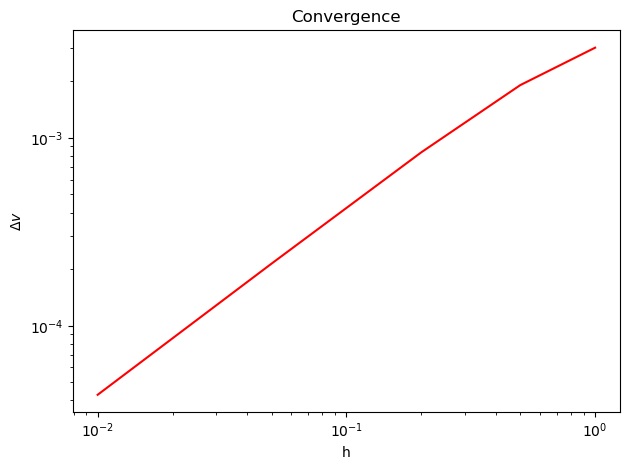

In [80]:
plt.title("Convergence")

plt.loglog(h_list, dv, "r", label=r"v")

plt.xlabel('h')
plt.ylabel('$\Delta v$')

plt.tight_layout()
plt.show()

In [95]:
# Test self-convergence for NFW profile

# Setup variables and parameters
r0 = 0 # dimensionless r
y0 = np.array([1, 0]) # initial conditions for phi and g
rmax = 100 # dimensionless r
G = 4.517e-30 # in parsecs and solar masses
rho_c = 1.478e-7
r_s = 10
delta_c = 10
h_list = [1, 0.5, 0.25, 0.125, 0.0625, 0.03125, 0.015625]
v_mid = []

# Repeat ODE solve for each step size, storing the difference from true value
for h in h_list:
    r, y = odeSolve(r0, y0, rmax, h, RHS, RHS_near0, NFW, RK4_step, G, rho_c, r_s, delta_c)
    rho = NFW(r, G, rho_c, r_s, delta_c)
    index = int(len(r) // 2 + 1)
    
    r1 = r / a_H
    g1 = y[:, 1] / (r*G*rho)

    v = (y[:, 1]*r)**0.5
    v_mid.append(v[index])

v_mid = np.array(v_mid)
dv = np.abs(v_mid[:-1] - v_mid[-1])

C:\Users\wxs07\AppData\Local\Temp\ipykernel_5784\2866294935.py:21: RuntimeWarning: invalid value encountered in divide
  g1 = y[:, 1] / (r*G*rho)


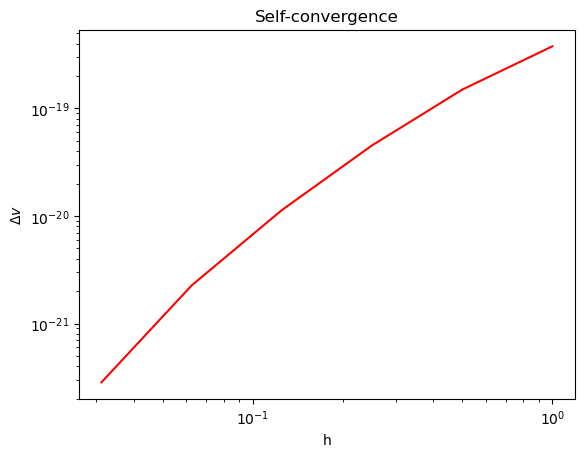

In [96]:
plt.title("Self-convergence")

plt.loglog(h_list[:-1], dv, "r", label=r"v")

plt.xlabel('h')
plt.ylabel('$\Delta v$')

plt.show()

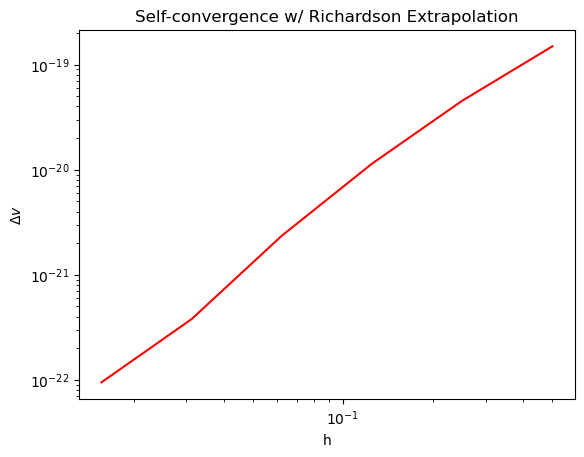

In [101]:
# Estimate error using richardson extrapolation
I_0_0 = v_mid[:-1]
I_0_1 = v_mid[1:]
I_1 = (4*I_0_1[-1] - I_0_0[-1]) / 3
dv = np.abs(I_0_1 - I_1)

plt.title("Self-convergence w/ Richardson Extrapolation")

plt.loglog(h_list[1:], dv, "r", label=r"v")

plt.xlabel('h')
plt.ylabel('$\Delta v$')

plt.show()